# Final Integrated Notebook
This notebok combines all the steps performed in the previous notebooks in order to train the model and make predicitions on the test data

importing Jupyter notebook from N1_Downsampling.ipynb
importing Jupyter notebook from N2_Preprocessing_FeatureExtraction.ipynb
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161620 entries, 0 to 161619
Data columns (total 3 columns):
qid              161620 non-null object
question_text    161620 non-null object
target           161620 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


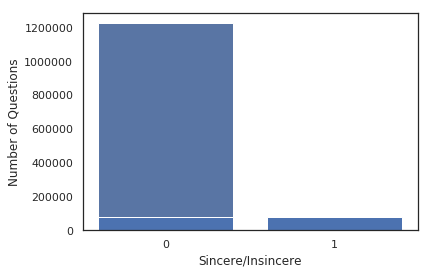

100%|██████████| 161620/161620 [00:14<00:00, 11418.24it/s]


In [1]:
import nltk
import pandas as pd
import string
import contractions
import os
from nltk import word_tokenize, sent_tokenize
from nltk.stem import  WordNetLemmatizer
import inflect
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import collections
import unicodedata
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import import_ipynb
import N1_Downsampling as down
import N2_Preprocessing_FeatureExtraction as pre

# Load Data

In [2]:
#loading train_data, downsampling it and then loading test data
train_data = pd.read_csv("./data/train.csv")
train_data = down.downsample(train_data)
test_data = pd.read_csv("./data/test.csv")

In [3]:
#extracting data required for training
X_train = train_data["question_text"]
Y_train = train_data["target"]
X_test = test_data["question_text"]

In [4]:
#computing maximum length of question available in train.csv
MAX_LEN = X_train.map(lambda x: len(x.split(' '))).max()

In [5]:
#setting constants
glove_word_embedding_path = "./data/glove.840B.300d/glove.840B.300d.txt"
LOG_DIR = "./checkpointing"
GLOVE_SIZE = 300
embedding_size=300
num_classes=2
batch_size = 128; 
hidden_layer_size = 32;time_steps = 100; element_size =1


test_seqlens = []
train_seqlens = []
new_x_train = []
new_y_train = []
new_x_test = []
#new_y_test = []


# Information extraction & manipulation
Functions used to extract information from the data provided and then converting that data 

In [6]:
class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "pad"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.lower().split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


#Uses the Lang class to return object which has word2index mapping, index2word, vocalbulary size and vocabulary
def get_question_metadata(question_list, reverse=False):
    question_repo = Lang()
    print("Read %s question(s) " % len(question_list))
    for question in question_list:
        question_repo.addSentence(question)
    return question_repo


#function to return batch of data by converting the words to index
def get_sentence_batch(batch_size,data_x,data_y,data_seqlens,input_metadata):
    
    #shuffling and creating training batch data of batch_size
    instance_indices = list(range(len(data_x)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    
    #converting sentence to index vector using word2index dictionary
    x = [[input_metadata.word2index[word] for word in data_x[i].lower().split(' ')]for i in batch]
    y = [data_y[i] for i in batch]
    seqlens = [data_seqlens[i] for i in batch]
    return x,y,seqlens

#function to return batch of test data in index form
def get_test_batch(i, batch_size,data_x, data_seqlens, input_metadata):
    
    #creating test batch data of batch_size
    instance_indices = list(range(len(data_x)))
    batch = instance_indices[i:i+batch_size]
    
    #converting sentence to index vector using word2index dictionary
    x = [[input_metadata.word2index[word] for word in data_x[i].lower().split(' ')]for i in batch]
    
    seqlens = [data_seqlens[i] for i in batch]
    return x, seqlens

#function to return the input question in index form
def get_test(data_x, input_metadata):
    x = []
    for word in data_x.lower().split(' '):
        if word == 'pad':
            x.append(2)
        else:
            x.append(input_metadata.word2index[word]) 
    return x



In [7]:
#Retrieving metadata
question_metadata = get_question_metadata(X_train)
question_metadata_test = get_question_metadata(X_test)

Read 161620 question(s) 
Read 56370 question(s) 


# Encoding and Data Padding

In [8]:
#representing output in the form of one-hot format
for i in range(len(Y_train)):
    label = Y_train[i]
    one_hot_encoding = [0]*2
    one_hot_encoding[label] = 1
    new_y_train.append(one_hot_encoding)

#making train data of equal size by padding
for ques in X_train:
    padded_sentence, sent_len = pre.make_input(ques, time_steps)
    new_x_train.append(padded_sentence)
    train_seqlens.append(sent_len)

#making test data of equal size by padding
for ques in X_test:
    padded_sentence, sent_len = pre.make_input(ques, time_steps)
    new_x_test.append(padded_sentence)
    test_seqlens.append(sent_len)


# Placeholders

In [9]:
#creating placeholders for data
_inputs = tf.placeholder(tf.int32,shape=[None, time_steps], name="inputs")
_labels = tf.placeholder(tf.float32, shape=[batch_size, num_classes], name="labels")

embedding_placeholder = tf.placeholder(tf.float32, [question_metadata.n_words,GLOVE_SIZE], name="emb")

#seqlens for dynamic calculations
_seqlens = tf.placeholder(tf.int32, shape=[None], name="seqlen")


# Pre-processing train data*

In [10]:
# """Replace contractions in string of text"""
contracted_input = X_train.progress_apply(lambda row:contractions.fix(row))

100%|██████████| 161620/161620 [00:37<00:00, 4263.07it/s]


In [11]:
#Text cleaning regarding punctuations, numerical values 
cleaned_text = contracted_input.progress_apply(lambda row:pre.clean_text(row))

100%|██████████| 161620/161620 [00:03<00:00, 53844.31it/s]


In [12]:
#tokenizing the words
word_tokenised = cleaned_text.progress_apply(lambda text:nltk.word_tokenize(text))

100%|██████████| 161620/161620 [00:34<00:00, 4670.84it/s]


In [13]:
#lemmatizing the verbs
lemmatized_words = word_tokenised.progress_apply(lambda word_list:pre.lemmatize_verbs(word_list))

100%|██████████| 161620/161620 [00:11<00:00, 13532.88it/s]


*We also added spelling correction using the edit distance method as taught in the lecture however it took too long to process on the data therefore we had to remove it.

In [14]:
#feature extraction
word2index,word2count,index2word,n_words = pre.extract_features(lemmatized_words)

# Using gloVe pre-trained embeddings

In [15]:
#gets the all the words in gloVe that are a part of our word to index map
def get_glove(path_to_glove,word2index_map):
    embedding_weights = {}
    count_all_words = 0
    with open(path_to_glove,'r') as f:  
        for line in f:
            vals = line.split(' ')
            word = str(vals[0])
            if word in word2index_map:                
                count_all_words += 1                                 
                coefs = np.asarray(vals[1:],dtype='float32')
                coefs /= np.linalg.norm(coefs)
                embedding_weights[word] = coefs
    mean = np.array(list(embedding_weights.values())).mean()
    return embedding_weights, mean

In [16]:
#Getting all the embeddings in a dictionary and the mean of the embeddings
word2embedding_dict, mean = get_glove(glove_word_embedding_path,word2index)

In [17]:
#Sets the embeddings of the words that are found and the words that are not found are set to mean of the embeddings
out_of_vocabulary = {}
embedding_matrix = np.zeros((question_metadata.n_words,GLOVE_SIZE))
for word,index in word2index.items():
    try:        
        word_embedding = word2embedding_dict[word]
        embedding_matrix[index,:] = word_embedding
    except:
        out_of_vocabulary[word] = word2index[word]
        embedding_matrix[index,:] = mean

In [18]:
print("vocabulary size is {}".format(n_words))
print("embedding found for {} percentage of vocab".format(((n_words-len(out_of_vocabulary))/n_words)*100))


vocabulary size is 71928
embedding found for 78.61055499944389 percentage of vocab


In [19]:
#to obtain word's vector, tf.nn.embedding_lookup is used and embeddings are set to whatever we assign to the embedding placeholder
with tf.variable_scope("embeddings", reuse= tf.AUTO_REUSE):
    
    embeddings = tf.Variable(tf.constant(0.0, shape=[question_metadata.n_words,GLOVE_SIZE]),trainable=False)
    embedding_init = embeddings.assign(embedding_placeholder)
    embed = tf.nn.embedding_lookup(embeddings, _inputs)


Instructions for updating:
Colocations handled automatically by placer.


# Feeding LSTM to Dynamic RNN

In [20]:

with tf.variable_scope("lstm", reuse= tf.AUTO_REUSE):
    
    lstm_cell = tf.nn.rnn_cell.LSTMCell(hidden_layer_size,forget_bias=1.0)
    
    #resolving the issue of adding noise as the form "PAD", by passing actual sequence length to tf.nn.dynamic_rnn() 
    output, states = tf.nn.dynamic_rnn(lstm_cell, embed, sequence_length = _seqlens,dtype=tf.float32)
       

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


# Linear Layer

In [21]:
#Settings weights and biases
with tf.variable_scope("linear_layer", reuse= tf.AUTO_REUSE):
    weights = {
        'linear_layer': tf.Variable(tf.truncated_normal([hidden_layer_size,num_classes],mean=0,stddev=.01))
    }

    biases = {
        'linear_layer': tf.Variable(tf.truncated_normal([num_classes],mean=0,stddev=.01))
    }

In [22]:
#We use the last valid output vector and feed it to a linear layer and then calculate softmax and cross-entropy loss
with tf.variable_scope("Optim", reuse= tf.AUTO_REUSE):
    final_output = tf.matmul(states[1],weights['linear_layer'])+ biases['linear_layer']
    softmax = tf.nn.softmax_cross_entropy_with_logits(logits=final_output,labels=_labels)
    cross_entropy = tf.reduce_mean(softmax)
    tf.summary.scalar("cross_entropy", cross_entropy)

#optimization step 
    train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(_labels,1),tf.argmax(final_output,1))
    accuracy = (tf.reduce_mean(tf.cast(correct_prediction,tf.float32)))*100

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Tensorboard Visualization & Training

In [23]:
# Merge all summary ops
merged = tf.summary.merge_all()

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter(LOG_DIR,graph=tf.get_default_graph())
    saver = tf.train.Saver()
    with open(os.path.join(LOG_DIR,'metadata.tsv'), "w") as metadata:
        metadata.write('Name\tClass\n')
        for k,v in index2word.items():
            metadata.write('%s\t%d\n' % (v, k))
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embeddings.name
    # Link embedding to its metadata file
    embedding.metadata_path = os.path.join(LOG_DIR,'metadata.tsv')
    #for visualization of embeddings
    projector.visualize_embeddings(train_writer, config)
    
    sess.run(tf.global_variables_initializer())
    #setting our embeddings to the embedding matrix created using gloVe
    sess.run(embedding_init, feed_dict= {embedding_placeholder: embedding_matrix})
    #training
    for step in range(1000):
        x_batch, y_batch, seqlen_batch = get_sentence_batch(batch_size,new_x_train,new_y_train,train_seqlens,question_metadata)
        summary,_ = sess.run([merged, train_step],feed_dict={_inputs:x_batch,_labels:y_batch,_seqlens:seqlen_batch})
        train_writer.add_summary(summary, step)
        if step % 100 == 0:
            #checkpointing the model
            saver.save(sess, os.path.join(LOG_DIR, "w2v_model.ckpt"), step)
            acc = sess.run(accuracy,feed_dict={_inputs:x_batch,_labels:y_batch,_seqlens:seqlen_batch})
            print("Training Accuracy at %d: %.5f" % (step,acc))
            
    # Normalize embeddings before using
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    normalized_embeddings_matrix = sess.run(normalized_embeddings)         
        
    

Training Accuracy at 0: 59.37500
Training Accuracy at 100: 42.18750
Training Accuracy at 200: 71.09375
Training Accuracy at 300: 71.09375
Training Accuracy at 400: 75.00000
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Training Accuracy at 500: 81.25000
Training Accuracy at 600: 76.56250
Training Accuracy at 700: 80.46875
Training Accuracy at 800: 80.46875
Training Accuracy at 900: 81.25000
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Running on test data
The model is loaded from the checkpoint and is run on the test data, the predictions are then saved to submission.csv and can be viewed there

In [24]:
sess = tf.Session()
saver.restore(sess, os.path.join(LOG_DIR, "w2v_model.ckpt-900"))
all_preds = []
for i in range(0, len(new_x_test), batch_size):
    x_test_batch, seq_lens_test = get_test_batch(i,batch_size,new_x_test, test_seqlens, question_metadata_test)   
    all_preds.extend(sess.run(tf.argmax(final_output,1), feed_dict={_inputs: x_test_batch, _seqlens: seq_lens_test}))
    #print(all_preds)
submit_df = pd.DataFrame({"qid": test_data["qid"], "prediction": all_preds})
submit_df.to_csv("submission.csv", index=False)  

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpointing/w2v_model.ckpt-900


# Try it out on your own!
Added just for fun.

In [ ]:
print("Ask a question to see if it's sincere or insincere")
your_question = input()
question_list = []
question_list.append(your_question)
padded_sentence, sent_len = pre.make_input(your_question, time_steps)
question_meta = get_question_metadata(question_list)
q_test = get_test(padded_sentence, question_meta)  
pred = sess.run(tf.argmax(final_output,1), feed_dict={_inputs:[q_test], _seqlens: [sent_len]})
if pred[0] == 0:
    print("That was a sincere question! Unfortunately, I don't have an answer.")
else:
    print("Insincere! Don't try to fool me!")

Ask a question to see if it's sincere or insincere
